Mean Load: 50 ; Variance Load: 10


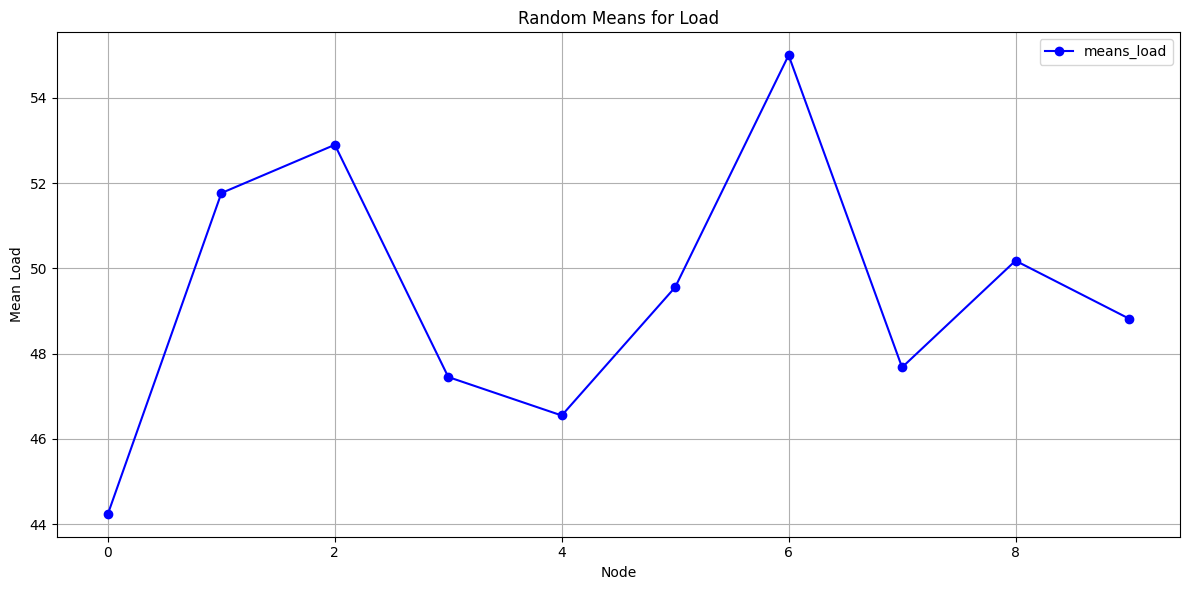

[44.24436783 51.76658912 52.89792621 47.45181101 46.55005692 49.55810142
 54.99787599 47.67872979 50.17960806 48.82224146]


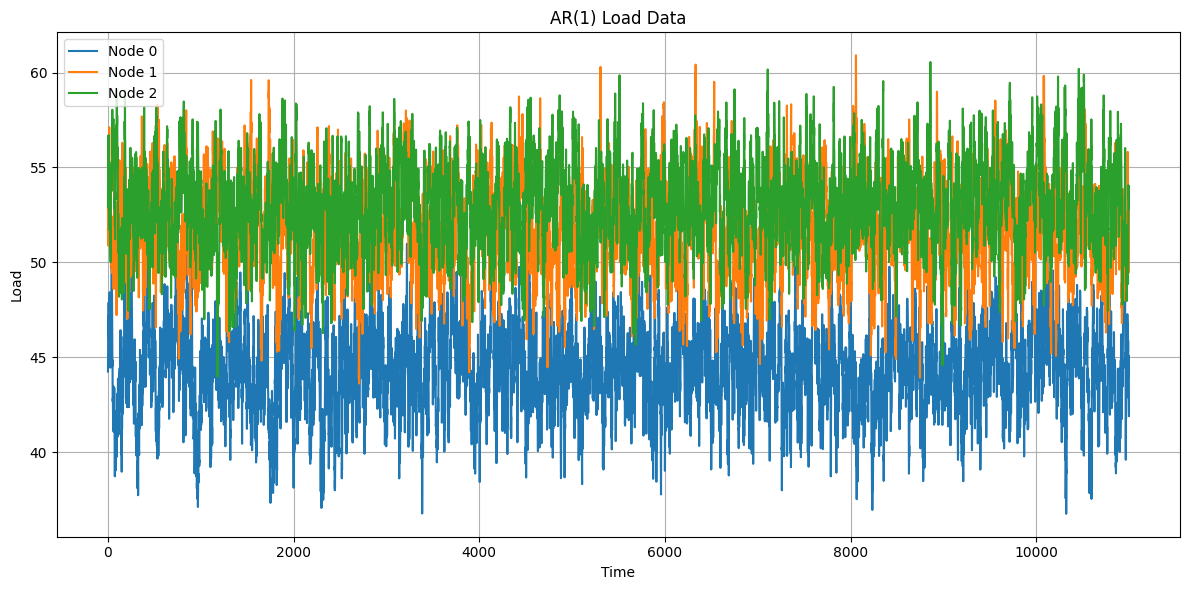

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import networkx as nx


# Function to generate random means
def generate_means(N, mean_load, var_load):
    print('Mean Load:', mean_load, '; Variance Load:', var_load)
    means_load = np.random.normal(loc=mean_load, scale=np.sqrt(var_load), size=N)

    # Plotting means_load
    plt.figure(figsize=(12, 6))
    plt.plot(means_load, marker='o', linestyle='-', color='b', label='means_load')
    plt.title('Random Means for Load')
    plt.xlabel('Node')
    plt.ylabel('Mean Load')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

    return means_load


# Function to generate IID data
def generate_iid_data(N, T, means_load):
    loads = np.array([np.random.normal(loc=means_load[i], scale=1, size=T) for i in range(N)])

    return loads, np.mean(loads, axis=1)


# Function to generate AR(1) data
def generate_ar1_data(N, T, means_load, theta):
    loads = np.zeros((N, T))

    def generate_ar1(theta, T, mean_node):
        ar1 = np.zeros(T)
        ar1[0] = mean_node
        for t in range(1, T):
            ar1[t] = theta * ar1[t - 1] + (1 - theta) * mean_node + np.random.normal(0, 1)
        return ar1

    for i in range(N):
        loads[i] = generate_ar1(theta, T, means_load[i])

    return loads, np.mean(loads, axis=1)


# 绘制指定范围内的AR(1)数据
def plot_ar1_data(load_data, start, end):
    N, T = load_data.shape
    time_steps = np.arange(start, end)

    plt.figure(figsize=(12, 6))
    for i in range(N):
        plt.plot(time_steps, load_data[i, start:end], label=f'Node {i}')
    plt.title('AR(1) Load Data')
    plt.xlabel('Time')
    plt.ylabel('Load')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()


N = 10
T_train = 10000
T_test = 1000
T = T_train + T_test
mean_load = 50
var_load = 10

means_load = generate_means(N, mean_load, var_load)
print(means_load)

# Generate IID data
load_iid, load_iid_means = generate_iid_data(N, T, means_load)

# Generate AR(1) data
theta = 0.9
load_ar1, load_ar1_means = generate_ar1_data(N, T, means_load, theta)
# Plotting AR(1) data
plot_ar1_data(load_ar1[:3], 0, T)

In [2]:
# 导入csv数据
data = pd.read_csv('load_ar1_data.csv')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch_geometric.nn import GCNConv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class GNNTimeSeriesPredictor:
    def __init__(self, data, T_train, batch_size=32, seq_length=20, input_size=10, output_size=10, learning_rate=0.001):
        self.data = data
        self.T_train = T_train
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Prepare the dataset
        self.train_data = torch.tensor(data[:, :T_train], dtype=torch.float32)
        self.test_data = torch.tensor(data[:, T_train:], dtype=torch.float32)

        sequences, targets = self.create_sequences(self.train_data, self.seq_length, self.T_train)
        self.train_dataset = TensorDataset(sequences, targets)
        self.dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

        # Create the model
        self.model = GNNModel(in_channels=self.input_size, out_channels=self.output_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

        # Assume a fully connected graph structure
        self.edge_index = torch.tensor(np.array([(i, j) for i in range(self.input_size) for j in range(self.input_size)]).T, dtype=torch.long)

    def create_sequences(self, data, seq_length, T_train):
        sequences = []
        targets = []
        for i in range(T_train - seq_length):
            seq = data[:, i: i + seq_length].T
            target = data[:, i + seq_length]
            sequences.append(seq)
            targets.append(target)
        return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(np.array(targets), dtype=torch.float32)

    def train(self, num_epochs=100):
        self.model.train()
        for epoch in tqdm(range(num_epochs), desc="Training"):
            for inputs, targets in self.dataloader:
                outputs = self.model(inputs, self.edge_index)
                loss = self.criterion(outputs, targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

    def test(self, T_test):
        total_loss = 0
        predictions = []
        true_values = []
        x_test = self.train_data[:, -self.seq_length:].T.unsqueeze(0)

        self.model.train()
        for i in range(T_test):
            pred = self.model(x_test, self.edge_index)
            real_value = self.test_data[:, i]

            predictions.append(pred.squeeze(0).detach().cpu().numpy())
            true_values.append(real_value.detach().cpu().numpy())

            loss = self.criterion(pred.squeeze(0), real_value)
            total_loss += loss.item()
            print(f'Step [{i + 1}/{T_test}], Loss: {loss.item():.4f}')

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            x_test = torch.cat((x_test[:, 1:, :], real_value.unsqueeze(0).unsqueeze(0)), dim=1)

        avg_loss = total_loss / T_test
        print(f'Average Loss over {T_test} steps: {avg_loss:.4f}')

        return np.array(predictions), np.array(true_values)

    def plot_predictions(self, predictions, true_values):
        plt.figure(figsize=(12, 6))
        plt.plot(predictions[:, 0], label='Predicted')
        plt.plot(true_values[:, 0], label='True')
        plt.xlabel('Time Steps')
        plt.ylabel('Load Value')
        plt.title('Predicted vs True Load Values for Node 1')
        plt.legend()
        plt.show()


class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)
        self.rnn = torch.nn.GRU(out_channels, out_channels, batch_first=True)
        self.fc = torch.nn.Linear(out_channels, out_channels)

    def forward(self, x, edge_index):
        batch_size, seq_len, num_nodes = x.size()

        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)

        out, _ = self.rnn(x)

        out = self.fc(out[:, -1, :])
        return out

# Example usage:
# predictor = GNNTimeSeriesPredictor(data=load_ar1, T_train=1000)
# predictor.train(num_epochs=100)
# predictions, true_values = predictor.test(T_test=1000)
# predictor.plot_predictions(predictions, true_values)


Training:  10%|█         | 10/100 [00:19<02:45,  1.84s/it]

Epoch [10/100], Loss: 1423.1968


Training:  20%|██        | 20/100 [00:39<02:38,  1.98s/it]

Epoch [20/100], Loss: 732.6263


Training:  30%|███       | 30/100 [00:58<02:25,  2.08s/it]

Epoch [30/100], Loss: 305.1709


Training:  40%|████      | 40/100 [01:18<02:07,  2.12s/it]

Epoch [40/100], Loss: 90.7092


Training:  50%|█████     | 50/100 [01:38<01:25,  1.70s/it]

Epoch [50/100], Loss: 16.5712


Training:  60%|██████    | 60/100 [01:57<01:27,  2.19s/it]

Epoch [60/100], Loss: 5.2805


Training:  70%|███████   | 70/100 [02:16<00:59,  1.97s/it]

Epoch [70/100], Loss: 5.6343


Training:  80%|████████  | 80/100 [02:35<00:37,  1.88s/it]

Epoch [80/100], Loss: 5.1034


Training:  90%|█████████ | 90/100 [03:00<00:21,  2.15s/it]

Epoch [90/100], Loss: 4.9085


Training: 100%|██████████| 100/100 [03:24<00:00,  2.05s/it]

Epoch [100/100], Loss: 4.9087
Step [1/1000], Loss: 2.0363
Step [2/1000], Loss: 2.0913
Step [3/1000], Loss: 3.0760
Step [4/1000], Loss: 4.6645
Step [5/1000], Loss: 4.3131
Step [6/1000], Loss: 5.4974
Step [7/1000], Loss: 4.8611
Step [8/1000], Loss: 4.7366
Step [9/1000], Loss: 4.2303
Step [10/1000], Loss: 3.6443
Step [11/1000], Loss: 5.6667
Step [12/1000], Loss: 4.9047
Step [13/1000], Loss: 3.0658
Step [14/1000], Loss: 3.8375
Step [15/1000], Loss: 3.8009
Step [16/1000], Loss: 2.4487
Step [17/1000], Loss: 2.0658
Step [18/1000], Loss: 1.9981
Step [19/1000], Loss: 3.8416
Step [20/1000], Loss: 6.3643
Step [21/1000], Loss: 6.0630
Step [22/1000], Loss: 7.1883
Step [23/1000], Loss: 8.3480
Step [24/1000], Loss: 8.1267
Step [25/1000], Loss: 6.3524
Step [26/1000], Loss: 5.7074
Step [27/1000], Loss: 6.9493
Step [28/1000], Loss: 7.4552
Step [29/1000], Loss: 3.8357
Step [30/1000], Loss: 4.4778
Step [31/1000], Loss: 5.4628
Step [32/1000], Loss: 4.9519
Step [33/1000], Loss: 4.7949
Step [34/1000], Loss: 

Step [46/1000], Loss: 3.2420
Step [47/1000], Loss: 3.8456
Step [48/1000], Loss: 3.4258
Step [49/1000], Loss: 1.7162
Step [50/1000], Loss: 4.1899
Step [51/1000], Loss: 4.2611
Step [52/1000], Loss: 4.2342
Step [53/1000], Loss: 4.3876
Step [54/1000], Loss: 4.2549
Step [55/1000], Loss: 5.3146
Step [56/1000], Loss: 5.8445
Step [57/1000], Loss: 5.0102
Step [58/1000], Loss: 4.1969
Step [59/1000], Loss: 2.1898
Step [60/1000], Loss: 3.3138
Step [61/1000], Loss: 4.7156
Step [62/1000], Loss: 4.0014
Step [63/1000], Loss: 4.8351
Step [64/1000], Loss: 3.9046
Step [65/1000], Loss: 5.3964
Step [66/1000], Loss: 5.6342
Step [67/1000], Loss: 5.9104
Step [68/1000], Loss: 5.4900
Step [69/1000], Loss: 5.3119
Step [70/1000], Loss: 3.7597
Step [71/1000], Loss: 4.7731
Step [72/1000], Loss: 4.6860
Step [73/1000], Loss: 5.6496
Step [74/1000], Loss: 5.9143
Step [75/1000], Loss: 4.1431
Step [76/1000], Loss: 3.4327
Step [77/1000], Loss: 3.2634
Step [78/1000], Loss: 3.7795
Step [79/1000], Loss: 1.8901
Step [80/1000]

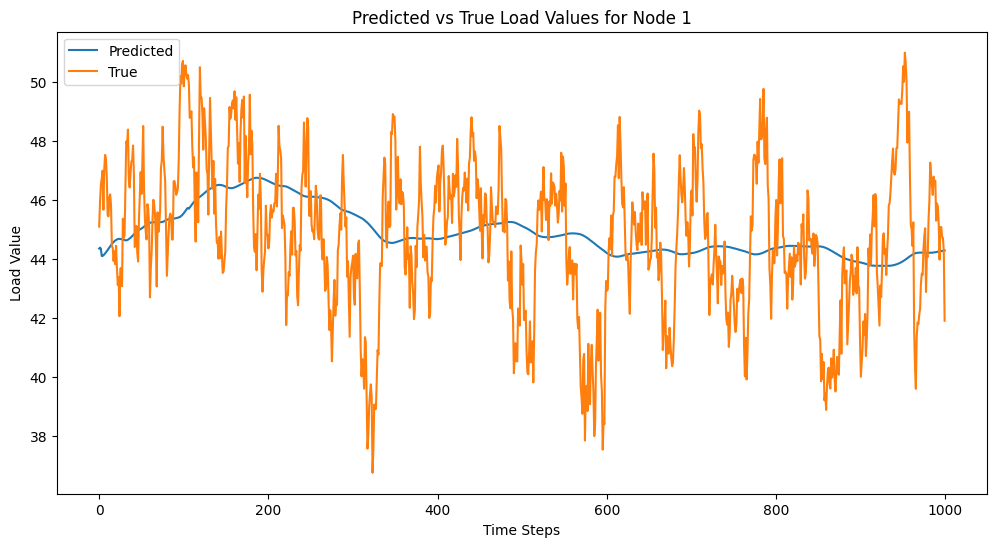

In [4]:
# 假设你已经准备好了 load_ar1, T_train, 和 T_test
data = load_ar1
T_train = 10000
T_test = 1000

# 1. 实例化预测器
predictor = GNNTimeSeriesPredictor(
    data=data,
    T_train=T_train,
    batch_size=64,
    seq_length=20,
    input_size=10,
    output_size=10,
    learning_rate=0.001
)

# 2. 训练模型
predictor.train(num_epochs=100)

# 3. 测试模型
predictions, true_values = predictor.test(T_test=T_test)

# 4. 绘制结果
predictor.plot_predictions(predictions, true_values)
